<a href="https://colab.research.google.com/github/allen17mv/Machine-Learning-Mini-Proj/blob/main/fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import os
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available()else 'cpu')
print(device)
device

cuda


device(type='cuda')

In [ ]:
transform = transforms.Compose([ transforms.ToTensor(), 
                              transforms.Normalize(mean=0.5,std=0.5)])

In [ ]:
train_dataset = FashionMNIST(train = True, transform = transform, root = os.getcwd(), download=True)
test_dataset = FashionMNIST(train = False, transform = transform, root = os.getcwd(), download=True)

Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw
Processing...
Done!


In [ ]:
print("Train dataset : ", train_dataset)
print("Test dataset : ", test_dataset)

Train dataset :  Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /content
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )
Test dataset :  Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: /content
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )


In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 8, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle = True)

In [ ]:
imgs,lbls = next(iter(train_loader))
print(imgs.size(),lbls.size())



torch.Size([8, 1, 28, 28]) torch.Size([8])


In [ ]:
def plot_images(imgs):
  img_grid = torchvision.utils.make_grid(imgs,nrow=4)
  img_np = img_grid.numpy()
  img_np = np.transpose(img_np,(1,2,0))
  mean=0.5
  std=0.5
  img_np = img_np * std + mean
  plt.figure(figsize=(8,8))
  plt.imshow(img_np)
  plt.title(imgs[1])
  plt.xticks([])
  plt.yticks([])
  plt.plot()


In [ ]:
target_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

['Sandal', 'Coat', 'Trouser', 'Sandal', 'Pullover', 'Pullover', 'Sneaker', 'Sneaker']


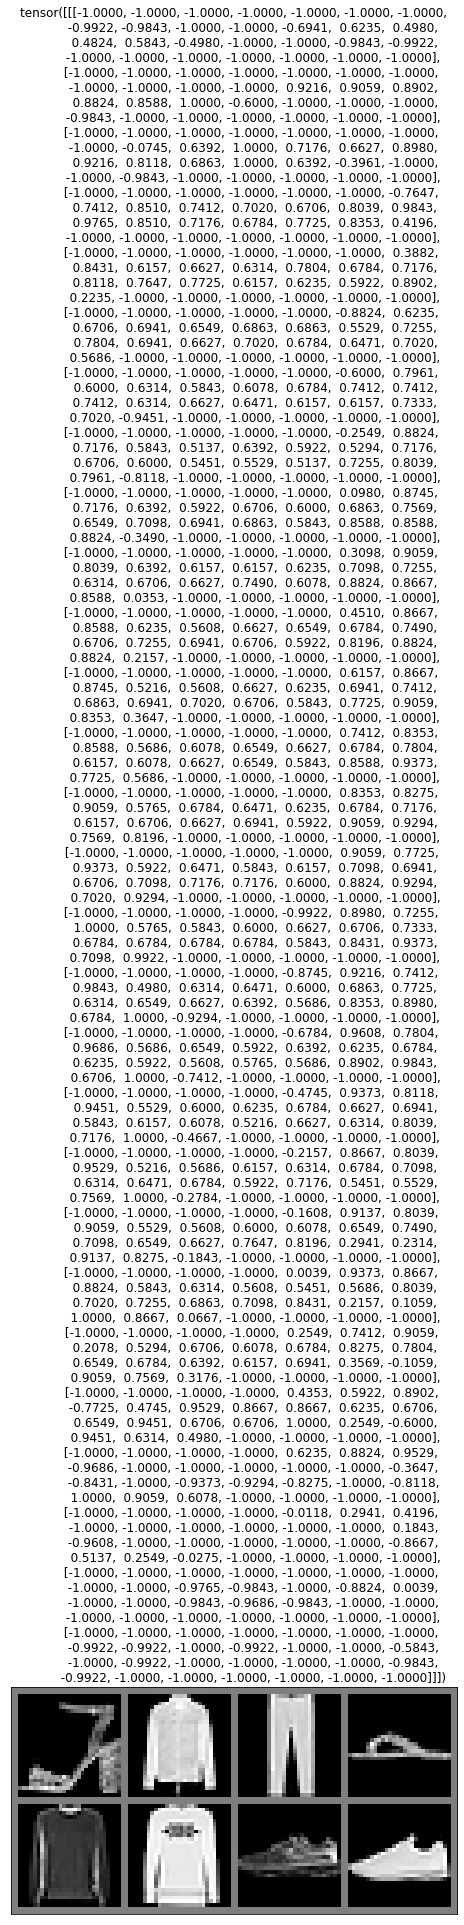

In [ ]:
plot_images(imgs)  
print([target_names[i] for i in lbls])

In [ ]:
class NN(nn.Module):
  def __init__(self):
    super(NN,self).__init__()
    self.net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=784,out_features=650),
        nn.ReLU(),
        nn.Linear(in_features=650,out_features=420),
        nn.ReLU(),
        nn.Linear(in_features=420,out_features=360),
        nn.ReLU(),
        nn.Linear(in_features=360,out_features=230),
        nn.ReLU(),
        nn.Linear(in_features=230,out_features=10),
        nn.Softmax(dim=1))
  def forward(self,X):
    outs = self.net(X)
    return outs

In [ ]:
def evaluate_on_gpu(model,dataloader):
  with torch.no_grad():
    total,correct=0,0
    for batch in dataloader:
      images, labels = batch
      images, labels = images.to(device),labels.to(device)
      out_probs = model(images)
      out_labels = torch.argmax(out_probs,axis=1)
      total += labels.size(0)
      correct += torch.sum(labels == out_labels).item()
  return 100*correct/total

def train_on_gpu(model,model_name,loss_criterion,optimizer,train_loader,test_loader,epochs=150):
  hist = { 'loss':[], 'train_acc' : [] , 'test_acc' : []}
  min_loss = 10e+10
  for epoch_num in tqdm(range(1,epochs+1),desc='Training', total = epochs):
    losses =[]
    for batch in train_loader:
      images, labels = batch
      images, labels = images.to(device),labels.to(device)
      optimizer.zero_grad()
      out = model(images)
      loss = loss_criterion(out,labels)
      losses.append(loss.item())
      loss.backward()
      optimizer.step()
      epoch = np.array(losses).mean()
    hist['loss'].append(epoch)

    if epoch<min_loss:
      min_loss = epoch
      torch.save(model.state_dict(),model_name +'.pth')
    train_acc = evaluate_on_gpu(model,train_loader)
    test_acc = evaluate_on_gpu(model,test_loader)
    hist['train_acc'].append(train_acc) 
    hist['test_acc'].append(test_acc)

  fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(14,7))
  ax[0].plot(range(1,epochs+1),hist['loss'],label='Loss')
  ax[0].plot(range(1,epochs+1),np.ones(shape=(epochs,))*min_loss, 'r--',alpha=0.5,label='Best Loss')
  ax[0].grid()
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss Value')
  ax[0].set_title('Epochs Vs Loss')

  ax[1].plot(hist['train_acc'], 'b-', label='Training Accuracy')
  ax[1].plot(hist['test_acc'],'m-',alpha=0.5,label='Test Accuracy')
  ax[1].grid()
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_title('Epochs Vs Accuracy')
  plt.legend()
  plt.show()




In [ ]:
#model = NN().to(device)
#loss_fn=nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters())
#train_on_gpu(model,'model_fashion',loss_fn,momentum,train_loader,test_loader,epochs=10)

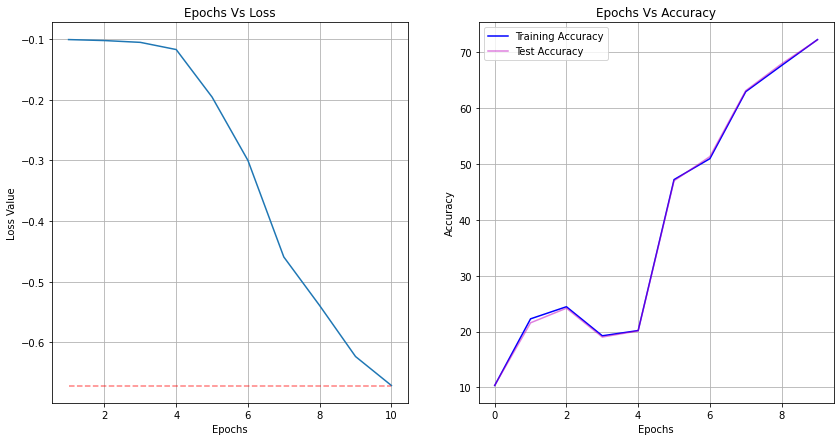

In [ ]:
model = NN().to(device)
momentum = optim.SGD(model.parameters(),lr=0.0001,momentum=0.9)
loss_fn = nn.NLLLoss()
train_on_gpu(model,'model_fashion',loss_fn,momentum,train_loader,test_loader,epochs=10)

In [ ]:
model = NN().to(device)
model.load_state_dict(torch.load('model_fashion.pth'))

<All keys matched successfully>

Predicted: ['Pullover', 'Sandal', 'Pullover', 'Bag', 'Bag', 'Coat', 'Sneaker', 'Ankle boot']
Actual: ['Pullover', 'Ankle boot', 'Pullover', 'Bag', 'Bag', 'Coat', 'Sneaker', 'Ankle boot']


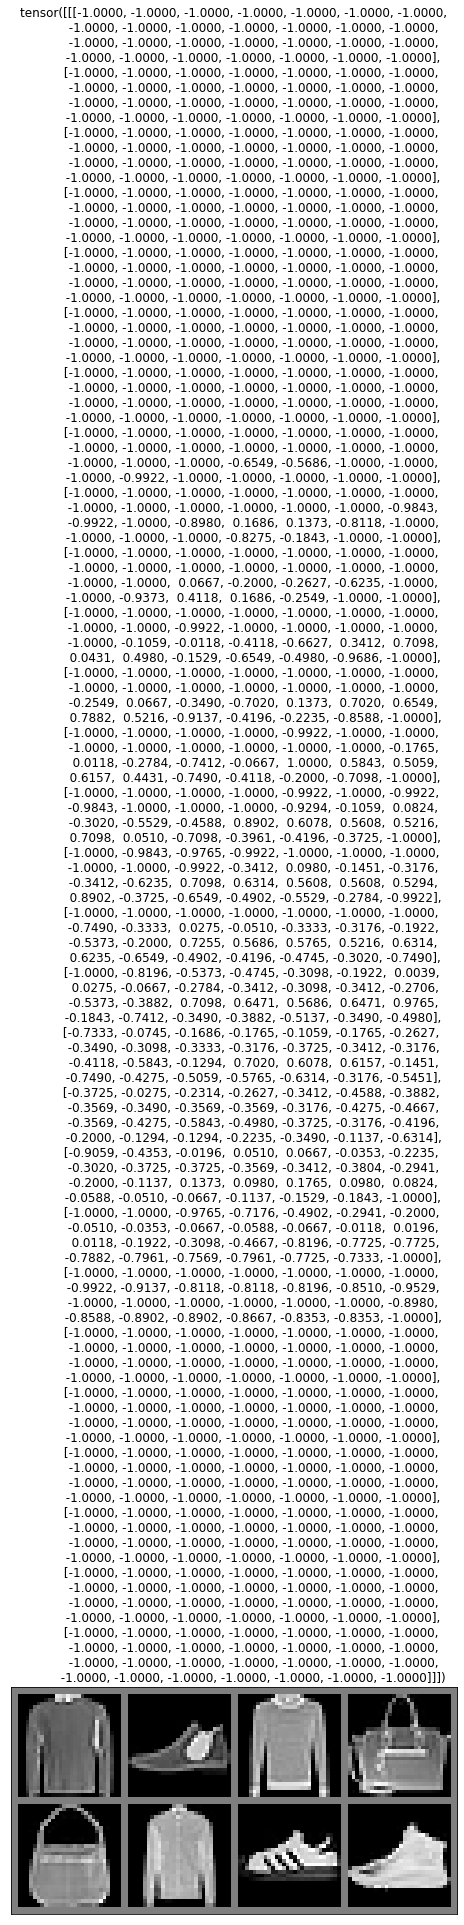

In [ ]:
test_imgs,test_lbls = next(iter(test_loader))
test_imgs,test_lbls = test_imgs.to(device),test_lbls.to(device)
plot_images(test_imgs.cpu())
out_probs = model(test_imgs)
out_labels = torch.argmax(out_probs,axis=1)
print('Predicted:',[target_names[i] for i in out_labels])
print('Actual:',[target_names[i] for i in test_lbls])

In [ ]:
print('Test Accuracy : ', evaluate_on_gpu(model,test_loader))

Test Accuracy :  72.25
